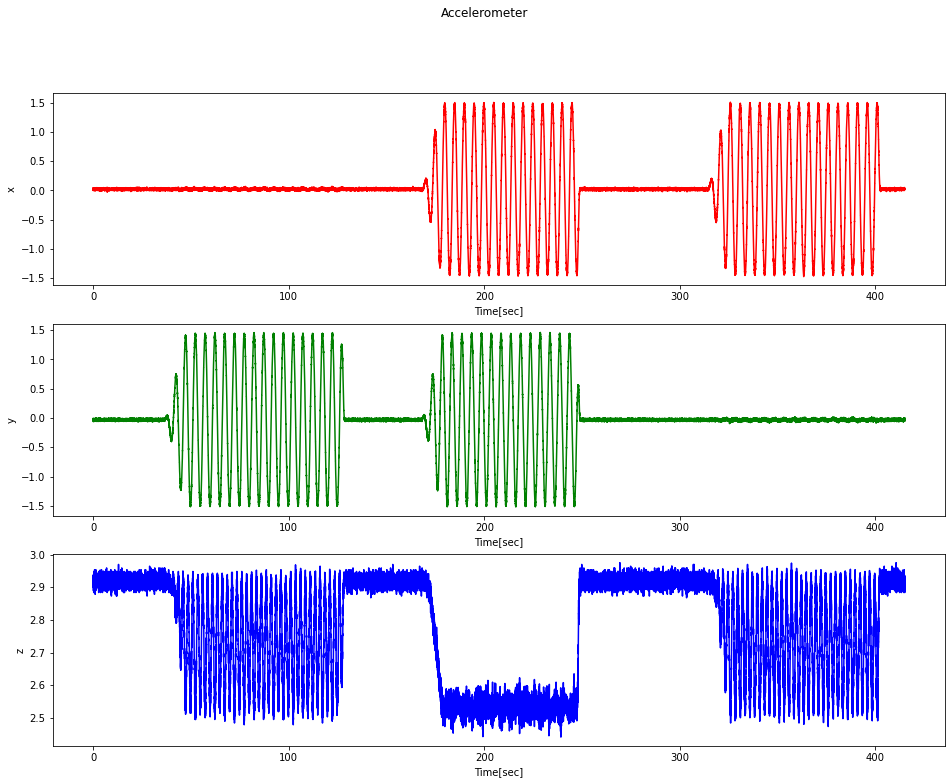

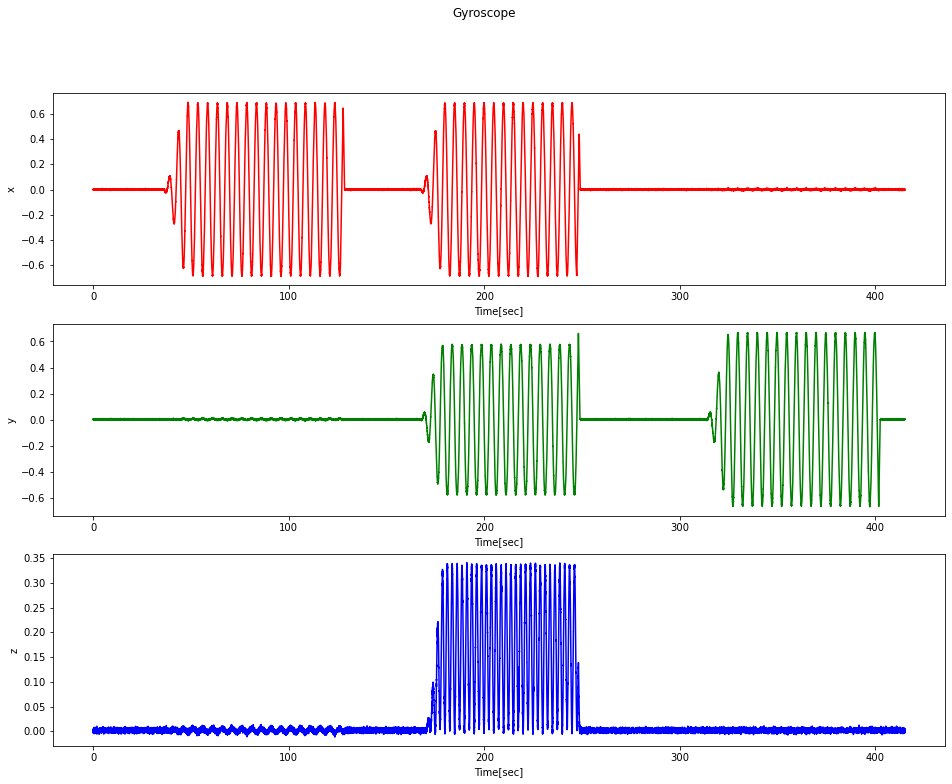

In [1]:
import scipy.io
import numpy as np
from matplotlib import pyplot as plt

from filters import KalmanFilter
from utils import (
    load_imu_data,
    plot_xyz,
    euler_from_gyro,
    euler_from_acce,
    euler_from_acce2,
)

dt, ts, gyro, acce = load_imu_data()
        
plot_xyz(ts, acce, 'Accelerometer')
plot_xyz(ts, gyro, 'Gyroscope')

# Naive Integration of Gyro

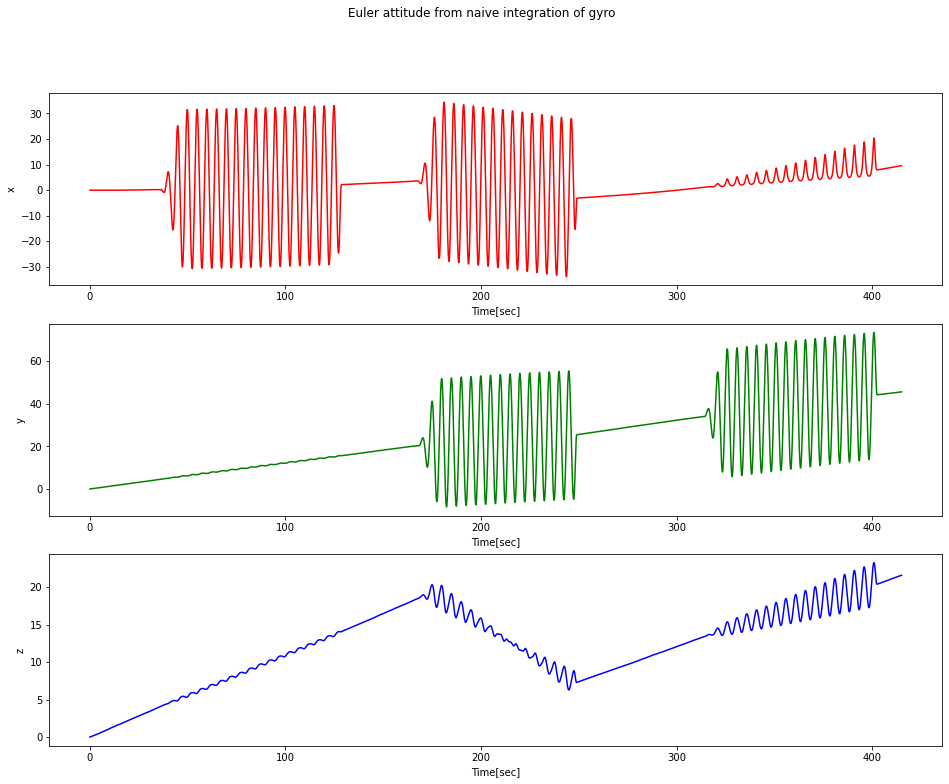

In [2]:
euler_g = euler_from_gyro(ts, gyro)
plot_xyz(ts, euler_g*180/np.pi, "Euler attitude from naive integration of gyro")

# Attitude from Accelerometer Only

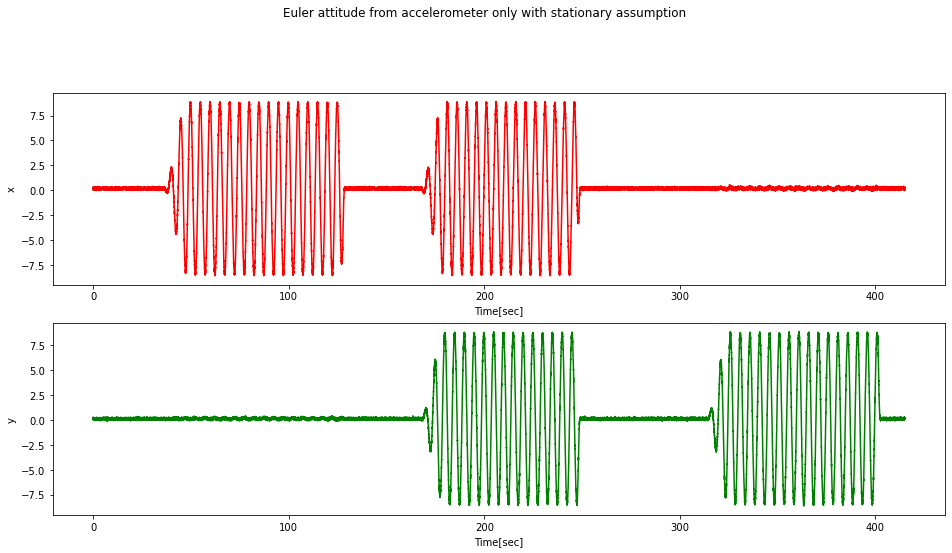

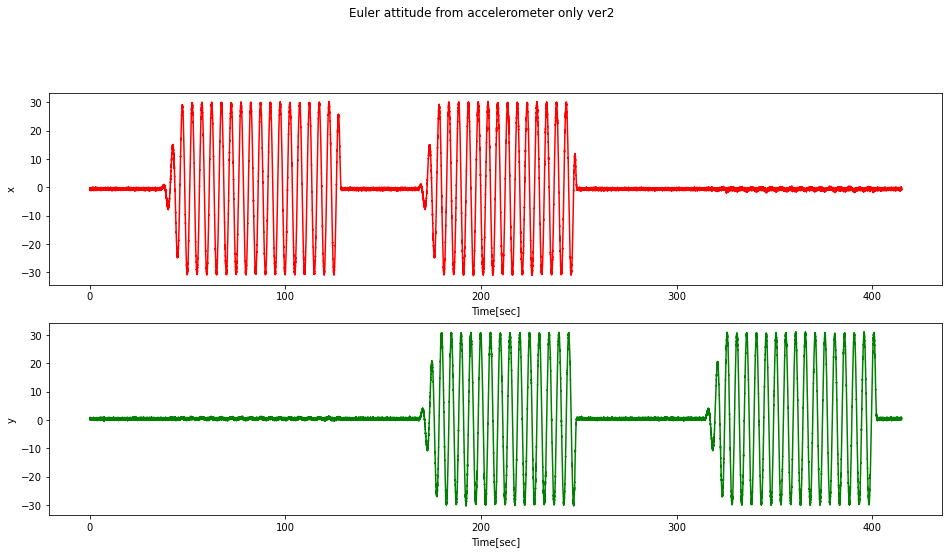

In [3]:
euler_a = euler_from_acce(acce)
plot_xyz(ts, euler_a[:, :2] * 180 / np.pi, "Euler attitude from accelerometer only with stationary assumption")
plot_xyz(ts, euler_from_acce2(acce)[:, :2] * 180 / np.pi, "Euler attitude from accelerometer only ver2")

# Sensor fusion with Kalman Filter

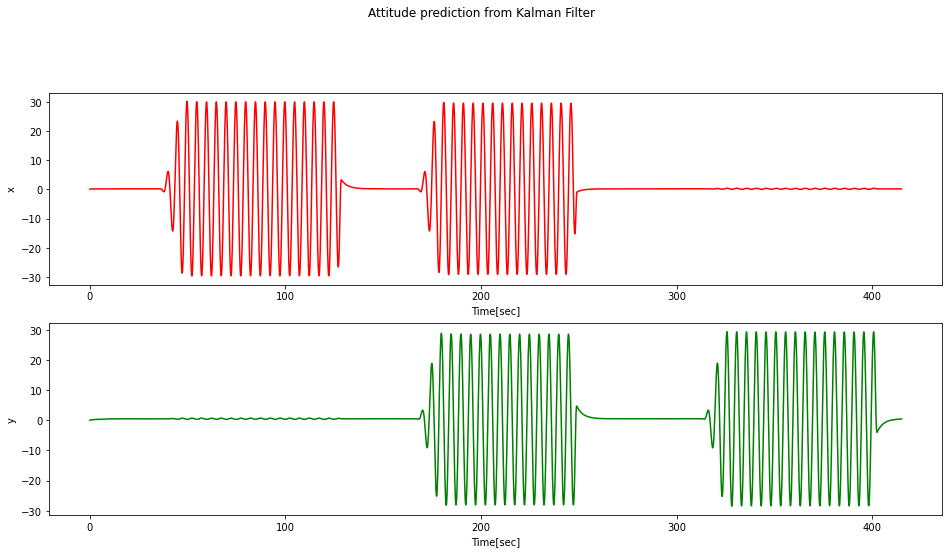

In [4]:
def gyro_to_quat_system_mat(gyro):
    p, q, r = gyro.T
    zeros = np.zeros_like(p)
    return np.stack([
        zeros, -p, -q, -r,
        p, zeros, r, -q,
        q, -r, zeros, p,
        r, q, -p, zeros,
    ], axis=1).reshape(-1, 4, 4) / 2

def euler_to_quat(euler):
    phi, theta, psi = euler.T
    
    sin_phi = np.sin(phi / 2)
    cos_phi = np.cos(phi / 2)
    sin_theta = np.sin(theta / 2)
    cos_theta = np.cos(theta / 2)
    sin_psi = np.sin(psi / 2)
    cos_psi = np.cos(psi / 2)
    
    return np.stack([
        cos_phi * cos_theta * cos_psi + sin_phi * sin_theta * sin_psi,
        sin_phi * cos_theta * cos_psi - cos_phi * sin_theta * sin_psi,
        cos_phi * sin_theta * cos_psi + sin_phi * cos_theta * sin_psi,
        cos_phi * cos_theta * sin_psi - sin_phi * sin_theta * cos_psi,
    ], axis=1)

def quat_to_euler(quat):
    w, x, y, z = quat.T
    phi = np.arctan2(2*(y*z + w*x), 1 - 2*(x**2 + y**2))
    theta = -np.arcsin(2*(x*z - w*y))
    psi = np.arctan2(2*(x*y + w*z), 1 - 2*(y**2 + z**2))
    return np.stack([phi, theta, psi], axis=1)

system_mat = gyro_to_quat_system_mat(gyro)
attitude_meas_from_acce = euler_to_quat(euler_a)
attitude_pred = np.zeros((len(ts), 4))

kf = KalmanFilter(
    x0 = np.array([[1, 0, 0, 0]]).T,
    P0 = np.eye(4),
    A = None,
    H = np.eye(4),
    Q = np.eye(4) * 1e-4,
    R = np.eye(4) * 10,
)

for i, (s, a) in enumerate(zip(system_mat, attitude_meas_from_acce)):
    kf.A = np.eye(4) + dt * s
    kf.update(a.reshape(4, 1))
    attitude_pred[i] = kf.get().reshape(-1)
    
attitude_pred_euler = quat_to_euler(attitude_pred) * 180 / np.pi
plot_xyz(ts, attitude_pred_euler[:, :2], "Attitude prediction from Kalman Filter")
